In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
from art.estimators.classification import TensorFlowV2Classifier, KerasClassifier
import matplotlib.pyplot as plt

c:\Users\dangw\anaconda3\envs\mnist\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\dangw\anaconda3\envs\mnist\lib\site-packages\art\estimators\certification\__init__.py:30: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data

In [4]:
import tensorflow as tf

# Force TensorFlow to use GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Avoid memory issues
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')  # Use only first GPU
        print("GPU is being used for ART attacks.")
    except RuntimeError as e:
        print(e)


GPU is being used for ART attacks.


In [5]:
def read_idx3_ubyte(file_path):

    with open(file_path, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        if magic_number != 2051:
            raise ValueError("Magic number is not 2051")
        
        num_images = int.from_bytes(f.read(4), byteorder='big')
        num_rows = int.from_bytes(f.read(4), byteorder='big')
        num_cols = int.from_bytes(f.read(4), byteorder='big')

        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num_images, num_rows, num_cols)

        return images

In [6]:
file_path = r"..\1. MNIST\train-images-idx3-ubyte\train-images.idx3-ubyte"
images = read_idx3_ubyte(file_path)

In [7]:
def read_idx1_ubyte(labels_path):

    with open(labels_path, "rb") as l:
        magic_number = int.from_bytes(l.read(4), "big")
        if magic_number != 2049:
            raise Exception("Magic number mismatch error")
        
        num_items = int.from_bytes(l.read(4), byteorder='big')

        labels = np.frombuffer(l.read(), dtype=np.uint8)

        if len(labels) != num_items:
            raise ValueError("Mismatch between number of labels and data size!")
        
        return labels

In [8]:
train_labels_path = r"..\1. MNIST\train-labels-idx1-ubyte\train-labels.idx1-ubyte"
train_labels = read_idx1_ubyte(train_labels_path)

In [9]:
test_images = read_idx3_ubyte(r"..\1. MNIST\t10k-images-idx3-ubyte/t10k-images.idx3-ubyte")
test_labels = read_idx1_ubyte(r"..\1. MNIST\t10k-labels-idx1-ubyte/t10k-labels.idx1-ubyte")

In [10]:
images = images / 255.0  # Normalizing the image array
test_images = test_images / 255.0

In [11]:
images = np.expand_dims(images, axis=-1)  # Shape: (num_samples, 28, 28, 1)
test_images = np.expand_dims(test_images, axis=-1)

## Model

In [12]:
model = tf.keras.models.load_model("1.MNIST/model_leNet.h5")
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [ ]:
training = model.fit(images, train_labels, epochs=1)

In [14]:
train_ds = tf.data.Dataset.from_tensor_slices((images, train_labels)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)

In [16]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Define loss function
loss_object = SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [ ]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [18]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [19]:
classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(28, 28, 1), clip_values=(0, 1), loss_object=loss_object, optimizer=optimizer, channels_first=False)

# Evasion

### Fast Gradient Method

In [1]:
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod

c:\Users\dangw\anaconda3\envs\mnist\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\dangw\anaconda3\envs\mnist\lib\site-packages\art\estimators\certification\__init__.py:30: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [ ]:
attack_fgsm = FastGradientMethod(
    estimator=classifier,
)

In [ ]:
test_images = test_images.numpy() if isinstance(test_images, tf.Tensor) else test_images

In [ ]:
test_images_adv = attack_fgsm.generate(x=test_images)

In [ ]:
y_test_pred = np.argmax(model(test_images_adv), axis=1)
accuracy_test_adv = np.sum(y_test_pred == test_labels) / test_labels.shape[0]
perturbation = np.mean(np.abs((test_images_adv - test_images)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test_adv * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 3.08%
Average perturbation: 0.16


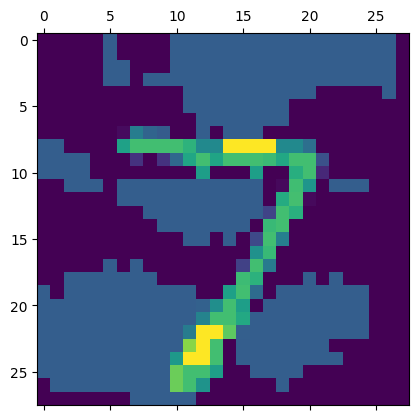

In [ ]:
plt.matshow(test_images_adv[0, :, :, 0])
plt.show()

### Evation Defense

In [ ]:
images = images.numpy() if isinstance(images, tf.Tensor) else images

In [ ]:
x_train_adv = attack_fgsm.generate(images)

In [ ]:
from art.defences.trainer import AdversarialTrainer

In [ ]:
trainer = AdversarialTrainer(classifier=classifier, attacks=attack_fgsm)

In [ ]:
trainer.fit(x_train_adv, train_labels)

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Adversarial training epochs: 100%|██████████| 20/20 [18:21<00:00, 55.07s/it]


In [ ]:
# Get predictions for clean test images
preds_clean = trainer.get_classifier().predict(test_images)
clean_acc = np.mean(np.argmax(preds_clean, axis=1) == test_labels)
print(f"Test accuracy on Clean test data: {clean_acc * 100:.2f}%")

# Get predictions for adversarial test images
preds_adv = trainer.get_classifier().predict(test_images_adv)
adv_acc = np.mean(np.argmax(preds_adv, axis=1) == test_labels)
print(f"Test accuracy on Adversarial test data: {adv_acc * 100:.2f}%")

Test accuracy on Clean test data: 49.92%
Test accuracy on Adversarial test data: 92.94%


# Poision

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.estimators.classification import TensorFlowV2Classifier

In [88]:
# Normalize the dataset
x_train = images.copy()
x_test = test_images.copy()

# Reshape for CNN input
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [89]:
# Convert labels to one-hot encoding
y_train = to_categorical(train_labels, 10)
y_test = to_categorical(test_labels, 10)

# Define a backdoor trigger pattern
def add_trigger(images, trigger_value=1.0, trigger_size=3):
    poisoned_images = images.copy()
    for img in poisoned_images:
        img[-trigger_size:, -trigger_size:] = trigger_value  # Bottom-right corner trigger
    return poisoned_images

In [90]:
# Poison a subset of training data
poison_fraction = 0.1  # 10% poisoned data
num_poisoned = int(poison_fraction * len(x_train))
poisoned_indices = np.random.choice(len(x_train), num_poisoned, replace=False)

target_label = 7  # Attacker's target class
x_train_poisoned = x_train.copy()
y_train_poisoned = y_train.copy()

In [91]:
# Modify images and labels for the poisoned subset
x_train_poisoned[poisoned_indices] = add_trigger(x_train_poisoned[poisoned_indices])
y_train_poisoned[poisoned_indices] = to_categorical([target_label] * num_poisoned, 10)

In [92]:
# Create a simple backdoor attack using PoisoningAttackBackdoor
def simple_backdoor(images):
    return add_trigger(images)

attack = PoisoningAttackBackdoor(simple_backdoor)
x_train_poisoned, y_train_poisoned = attack.poison(x_train_poisoned, y_train_poisoned)

In [80]:
model.fit(x_train_poisoned, y_train_poisoned, epochs=5, batch_size=64, validation_data=(x_test, y_test))

# Evaluate clean accuracy
clean_accuracy = model.evaluate(x_test, y_test, verbose=0)[1]
print(f'Clean Test Accuracy: {clean_accuracy * 100:.2f}%')

# Evaluate backdoor success rate
x_test_triggered = add_trigger(x_test)
y_test_targeted = to_categorical([target_label] * len(y_test), 10)
backdoor_success_rate = model.evaluate(x_test_triggered, y_test_targeted, verbose=0)[1]
print(f'Backdoor Success Rate: {backdoor_success_rate * 100:.2f}%')

Epoch 1/5
938/938 [==============================] - 3s 3ms/step - loss: 0.4837 - accuracy: 0.8568 - val_loss: 0.1197 - val_accuracy: 0.9827
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3598 - accuracy: 0.8936 - val_loss: 0.1382 - val_accuracy: 0.9852
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3363 - accuracy: 0.8991 - val_loss: 0.1303 - val_accuracy: 0.9890
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3216 - accuracy: 0.9021 - val_loss: 0.2018 - val_accuracy: 0.9794
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3109 - accuracy: 0.9048 - val_loss: 0.1417 - val_accuracy: 0.9850
Clean Test Accuracy: 98.50%
Backdoor Success Rate: 11.21%
